In [6]:
from datasets import load_dataset

ds = load_dataset("eltorio/ROCOv2-radiology")

In [8]:
pip install torch torchvision


  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 1.8/212.5 MB 10.3 MB/s eta 0:00:21
    --------------------------------------- 3.4/212.5 MB 9.4 MB/s eta 0:00:23
    --------------------------------------- 5.0/212.5 MB 8.2 MB/s eta 0:00:26
   - -------------------------------------- 6.3/212.5 MB 7.8 MB/s eta 0:00:27
   - -------------------------------------- 7.6/212.5 MB 7.5 MB/s eta 0:00:28
   - -------------------------------------- 8.9/212.5 MB 7.4 MB/s eta 0:00:28
   - -------------------------------------- 10.2/212.5 MB 7.3 MB/s eta 0:00:28
   -- ------------------------------------- 11.8/212.5 MB 7.2 MB/s eta 0:00:29
   -- ------------------------------------- 13.1/212.5 MB 7.1 MB/s eta 0:00:29
   -- ------------------------------------- 14.4/212.5 MB 7.0 MB/s eta 0:00:29
   -- ------------------------------------- 15.7/212.5 MB 7.0 MB/s eta 0:00:29
   


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:

from torchvision import models, transforms


In [10]:
from PIL import Image

In [11]:
import torch

In [12]:
# Inspect the dataset structure
print(ds)
print(ds['train'][0])  # Print the first example in the training set

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'caption', 'cui'],
        num_rows: 59962
    })
    validation: Dataset({
        features: ['image', 'image_id', 'caption', 'cui'],
        num_rows: 9904
    })
    test: Dataset({
        features: ['image', 'image_id', 'caption', 'cui'],
        num_rows: 9927
    })
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=682x748 at 0x2110DE60050>, 'image_id': 'ROCOv2_2023_train_000001', 'caption': 'Head CT demonstrating left parotiditis.', 'cui': ['C0040405']}


In [ ]:
# Extract images and captions from the dataset
images = [example["image"] for example in ds["train"]]
captions = [example["caption"] for example in ds["train"]]

# Print the first 5 captions to verify
print(captions[:2])

In [ ]:
import wandb
import psutil
import GPUtil
print(GPUtil.getGPUs())


In [8]:

# Get all available GPUs
gpus = GPUtil.getGPUs()

# Print details for each GPU
for gpu in gpus:
    print(f"GPU ID: {gpu.id}")
    print(f"Name: {gpu.name}")
    print(f"Load: {gpu.load * 100:.2f}%")
    print(f"Memory Free: {gpu.memoryFree}MB")
    print(f"Memory Used: {gpu.memoryUsed}MB")
    print(f"Memory Total: {gpu.memoryTotal}MB")
    print(f"Temperature: {gpu.temperature}°C")
    print("-" * 40)

GPU ID: 0
Name: Tesla P100-PCIE-12GB
Load: 0.00%
Memory Free: 13.0MB
Memory Used: 12180.0MB
Memory Total: 12288.0MB
Temperature: 34.0°C
----------------------------------------
GPU ID: 1
Name: Tesla P100-PCIE-16GB
Load: 0.00%
Memory Free: 16274.0MB
Memory Used: 2.0MB
Memory Total: 16384.0MB
Temperature: 38.0°C
----------------------------------------
GPU ID: 2
Name: Tesla P100-PCIE-12GB
Load: 0.00%
Memory Free: 12191.0MB
Memory Used: 2.0MB
Memory Total: 12288.0MB
Temperature: 36.0°C
----------------------------------------
GPU ID: 3
Name: Tesla P100-PCIE-12GB
Load: 0.00%
Memory Free: 12191.0MB
Memory Used: 2.0MB
Memory Total: 12288.0MB
Temperature: 31.0°C
----------------------------------------
GPU ID: 4
Name: Tesla P100-PCIE-16GB
Load: 0.00%
Memory Free: 16274.0MB
Memory Used: 2.0MB
Memory Total: 16384.0MB
Temperature: 31.0°C
----------------------------------------
GPU ID: 5
Name: Tesla P100-PCIE-16GB
Load: 0.00%
Memory Free: 16274.0MB
Memory Used: 2.0MB
Memory Total: 16384.0MB
Temp

In [9]:
import os

# Set GPU ID 4 as the visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [10]:
import numpy as np
import json

In [11]:
# Initialize wandb
wandb.init(project="medical-image-captioning", name="feature-extraction_testrun2")

# Log configuration
wandb.config.update({
    "model": "ResNet50",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "image_size": (224, 224),
    "normalization_mean": [0.485, 0.456, 0.406],
    "normalization_std": [0.229, 0.224, 0.225]
})

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pre-trained ResNet model and move it to the GPU
resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()

# Define a transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features from an image
def extract_features(image):
    # Ensure the image is in RGB format
    image = image.convert("RGB")
    
    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    
    # Extract features using the model
    with torch.no_grad():
        features = resnet(image_tensor)
    
    return features.squeeze().cpu().numpy()  # Move back to CPU for further processing

# Initialize lists to store features and captions
all_features = []
all_captions = []

# Extract features for all images and log to wandb
for idx, (image, caption) in enumerate(zip(images, captions)):
    features = extract_features(image)
    all_features.append(features)
    all_captions.append(caption)
    
    # Log features and captions to wandb
    wandb.log({
        "image_index": idx,
        "caption": caption,
        "features": features.tolist(),  # Log features as a list
        "image": wandb.Image(image, caption=caption)
    })

torch.save(all_features, 'all_features.pt')
torch.save(all_captions, 'all_captions.pt')

print("✅ Features and Captions saved successfully!")

# Save features and captions to local files
np.save("features.npy", np.array(all_features))  # Save features as a NumPy array
with open("captions.json", "w") as f:
    json.dump(all_captions, f)  # Save captions as a JSON file

print("Features and captions saved locally.")

# Finish wandb run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: medtekki (medtekki-university-of-stavanger) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


/home/ansatt/eriksh/.venv/dat550/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ansatt/eriksh/.venv/dat550/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Features and captions saved locally.


In [12]:
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


In [13]:
api = wandb.Api()
runs = api.runs("medtekki-university-of-stavanger/medical-image-captioning")
for run in runs:
    print(f"Run Name: {run.name}, Run ID: {run.id}")

Run Name: feature-extraction, Run ID: stdmmc54
Run Name: feature-extraction2, Run ID: htt1q4t7
Run Name: feature-extraction3, Run ID: pon7o8gv
Run Name: feature-extraction_ichi, Run ID: sgqh7c5b
Run Name: feature-extraction_ni, Run ID: tcm61qyd
Run Name: feature-extraction_ni, Run ID: zp4419tw
Run Name: feature-extraction_san, Run ID: so58vuk3
Run Name: feature-extraction_ni, Run ID: y8i2dwf9
Run Name: feature-extraction_chi, Run ID: lity27dr
Run Name: feature-extraction_go, Run ID: ompi5td7
Run Name: feature-extraction_testrun, Run ID: 6lunze22
Run Name: feature-extraction_testrun2, Run ID: pr9gob5i
Run Name: decision-tree-mps, Run ID: k1a5rxte
Run Name: decision-tree-mps_ichi, Run ID: s3yvrg1s
Run Name: decision-tree-mps_ni, Run ID: y2dojsyl


In [14]:
run = api.run(f"medtekki-university-of-stavanger/medical-image-captioning/sgqh7c5b")
for log in run.history():
    print(log)

_runtime
features
_timestamp
image_index
_step
image
caption


In [17]:
print(features.shape)

(1000,)


In [ ]:
import wandb
import numpy as np
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Initialize W&B
wandb.init(project="medical-image-captioning", name="decision-tree-classifier_go4")

# Load the saved features and captions
features = np.load("features.npy")  # Load features from the .npy file
with open("captions.json", "r") as f:
    captions = json.load(f)  # Load captions from the .json file

# Step 1: Convert captions to numerical labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(captions)

# Log label classes
wandb.config.label_classes = label_encoder.classes_.tolist()

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 3: Train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluate the Classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Log metrics to W&B
wandb.log({"accuracy": accuracy, "classification_report": report})

# Step 5: Log confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.close()

# Optional: Save and log the trained model
joblib.dump(clf, "decision_tree_model.pkl")
wandb.save("decision_tree_model.pkl")

# Finish W&B run
wandb.finish()

wandb: WARNING Serializing object of type list that is 477192 bytes
wandb: WARNING Serializing object of type list that is 499960 bytes


## TF-IDF + KMeans Clustering

In [3]:
import json
import numpy as np
# Load the saved features and captions
features = np.load("features.npy")  # Load features from the .npy file
with open("captions.json", "r") as f:
    captions = json.load(f)  # Load captions from the .json file

# Verify the loaded captions
print(f"Number of captions loaded: {len(captions)}")
print("First 5 captions:", captions[:5])

Number of captions loaded: 59962
First 5 captions: ['Head CT demonstrating left parotiditis.', 'Acquired renal cysts in end-stage renal failure: 16-year-old girl with Alport syndrome and peritoneal dialysis from the age of 2\xa0years', 'Computed tomography of the chest showing the right breast nodule with irregular margins', 'Lateral view of the sacrum showing the low contrast between bone and soft tissue.', 'Thoracic CT scan showing perihilar pulmonary lymphadenomegaly']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Convert captions to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(captions)

# Cluster captions into k groups
k = 30  # Choose the number of clusters (adjust based on your dataset)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map captions to their clusters
clustered_captions = {caption: cluster for caption, cluster in zip(captions, clusters)}

# Replace captions with cluster labels
labels = clusters
print(f"Number of clusters: {k}")

Number of clusters: 30


Accuracy: 0.18185608271491704
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.29      0.30      2929
           1       0.04      0.04      0.04       147
           2       0.10      0.11      0.10       330
           3       0.12      0.14      0.13       145
           4       0.13      0.13      0.13       692
           5       0.22      0.20      0.21       398
           6       0.07      0.07      0.07       633
           7       0.18      0.18      0.18       808
           8       0.18      0.20      0.19       571
           9       0.04      0.05      0.05       329
          10       0.15      0.16      0.16       428
          11       0.09      0.09      0.09       215
          12       0.16      0.17      0.16       189
          13       0.17      0.15      0.16       329
          14       0.05      0.05      0.05       312
          15       0.27      0.25      0.26       118
          16       0.00    

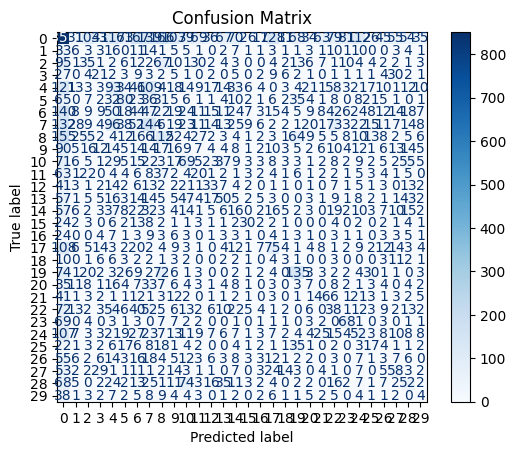

Model saved as decision_tree_model.pkl


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
joblib.dump(clf, "decision_tree_model.pkl")
print("Model saved as decision_tree_model.pkl")

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Convert captions to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(captions)

# Cluster captions into k groups
k = 10  # Choose the number of clusters (adjust based on your dataset)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map captions to their clusters
clustered_captions = {caption: cluster for caption, cluster in zip(captions, clusters)}

# Replace captions with cluster labels
labels = clusters
print(f"Number of clusters: {k}")

Number of clusters: 10


Accuracy: 0.3795547402651547
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.54      0.56      4958
           1       0.25      0.26      0.25      1255
           2       0.31      0.29      0.30       738
           3       0.06      0.07      0.06       506
           4       0.26      0.31      0.28       673
           5       0.11      0.11      0.11       659
           6       0.40      0.40      0.40      1104
           7       0.25      0.27      0.26       582
           8       0.42      0.42      0.42       491
           9       0.21      0.19      0.20      1027

    accuracy                           0.38     11993
   macro avg       0.28      0.29      0.28     11993
weighted avg       0.39      0.38      0.38     11993



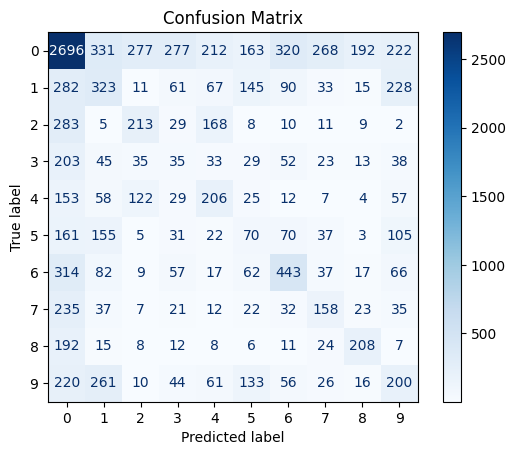

Model saved as decision_tree_model10classes.pkl


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
joblib.dump(clf, "decision_tree_model_10classes.pkl")
print("Model saved as decision_tree_model10classes.pkl")

In [11]:
import numpy as np
import json

# Load the saved features and captions
features = np.load("features.npy")  # Load features from the .npy file
with open("captions.json", "r") as f:
    captions = json.load(f)  # Load captions from the .json file

# Ensure clustered_captions is created during clustering
# Example: clustered_captions = {caption: cluster for caption, cluster in zip(captions, clusters)}

# Predict the cluster for a new image using its pre-extracted features
new_image_index = 0  # Replace with the index of the new image
new_image_features = features[new_image_index]  # Use the pre-extracted features
predicted_cluster = clf.predict([new_image_features])[0]

# Retrieve all captions belonging to the predicted cluster
cluster_captions = [caption for caption, cluster in clustered_captions.items() if cluster == predicted_cluster]

# Select a representative caption (e.g., the first one or a random one)
if cluster_captions:
    representative_caption = cluster_captions[0]  # You can also use random.choice(cluster_captions)
    print("Generated Caption:", representative_caption)
else:
    print("No captions found for the predicted cluster.")

# Print the original caption for the same image
original_caption = captions[new_image_index]
print("Original Caption:", original_caption)

Generated Caption: Head CT demonstrating left parotiditis.
Original Caption: Head CT demonstrating left parotiditis.


In [12]:
import numpy as np
import json
import random

# Load the saved features and captions
features = np.load("features.npy")  # Load features from the .npy file
with open("captions.json", "r") as f:
    captions = json.load(f)  # Load captions from the .json file

# Ensure clustered_captions is created during clustering
# Example: clustered_captions = {caption: cluster for caption, cluster in zip(captions, clusters)}

# Select 10 random indices
random_indices = random.sample(range(len(features)), 10)

# Iterate over the selected indices
for idx in random_indices:
    # Get the features and original caption for the current image
    new_image_features = features[idx]
    original_caption = captions[idx]

    # Predict the cluster for the current image
    predicted_cluster = clf.predict([new_image_features])[0]

    # Retrieve all captions belonging to the predicted cluster
    cluster_captions = [caption for caption, cluster in clustered_captions.items() if cluster == predicted_cluster]

    # Select a representative caption (e.g., the first one or a random one)
    if cluster_captions:
        representative_caption = cluster_captions[0]  # You can also use random.choice(cluster_captions)
    else:
        representative_caption = "No captions found for the predicted cluster."

    # Print the original and generated captions
    print(f"Image Index: {idx}")
    print(f"Original Caption: {original_caption}")
    print(f"Generated Caption: {representative_caption}")
    print("-" * 50)

Image Index: 36312
Original Caption: Chest computed tomography demonstrating severe pulmonary oedema
Generated Caption: Head CT demonstrating left parotiditis.
--------------------------------------------------
Image Index: 38188
Original Caption: T2 sagittal hyperintense intramedullary signal from T6 to conus medullaris.
Generated Caption: Enhanced magnetic resonance imaging of head revealed bilateral cerebral and cerebellar hemispheres abnormal meningeal enhancement.
--------------------------------------------------
Image Index: 33435
Original Caption:  T2 weighted MR lumbar spine. Sagittal view of MR lumbar spine at initial presentation. T2 weighted image shows extensive edema signal at the L3 vertebral body and severe retropulsion of the vertebral body causing severe spinal canal stenosis (marked by the black arrow). 
Generated Caption: Enhanced magnetic resonance imaging of head revealed bilateral cerebral and cerebellar hemispheres abnormal meningeal enhancement.
---------------

In [14]:
# Step 1: Load the dataset
from datasets import load_dataset
ds = load_dataset("eltorio/ROCOv2-radiology")

# Step 2: Extract images and captions
images = [example["image"] for example in ds["train"]]
captions = [example["caption"] for example in ds["train"]]

# Step 3: Verify the data
print(f"Number of images loaded: {len(images)}")
print(f"First 5 captions: {captions[:5]}")

/home/ansatt/eriksh/.venv/dat550/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of images loaded: 59962
First 5 captions: ['Head CT demonstrating left parotiditis.', 'Acquired renal cysts in end-stage renal failure: 16-year-old girl with Alport syndrome and peritoneal dialysis from the age of 2\xa0years', 'Computed tomography of the chest showing the right breast nodule with irregular margins', 'Lateral view of the sacrum showing the low contrast between bone and soft tissue.', 'Thoracic CT scan showing perihilar pulmonary lymphadenomegaly']


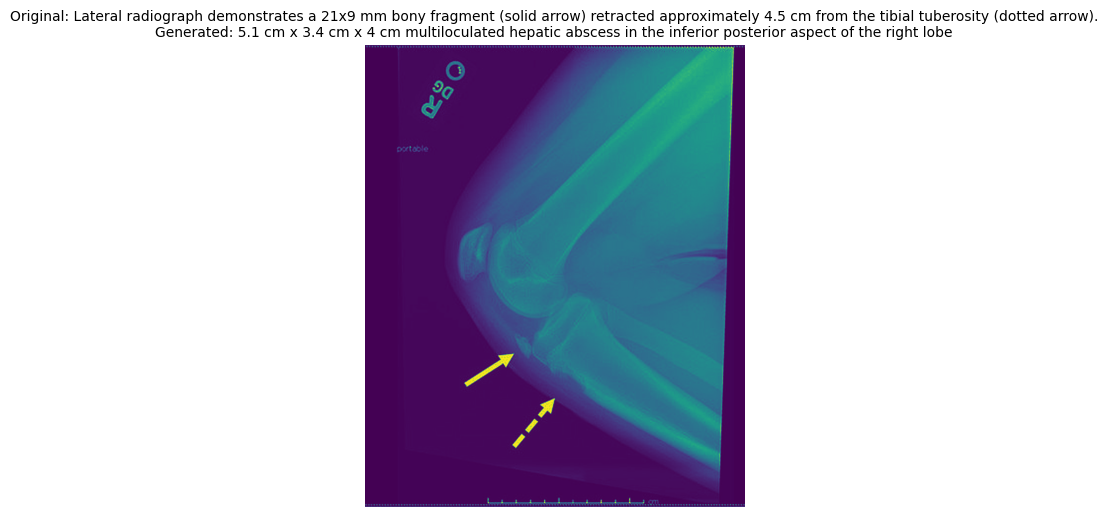

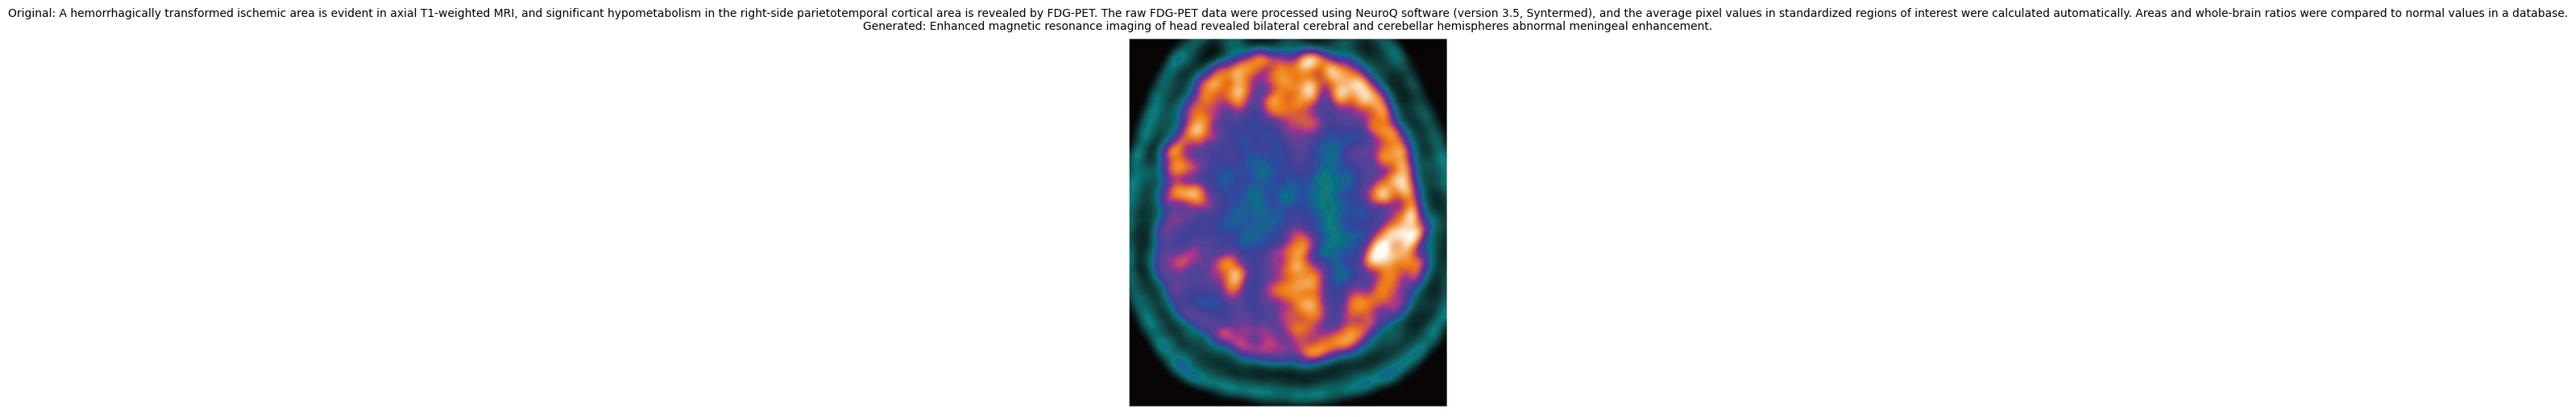

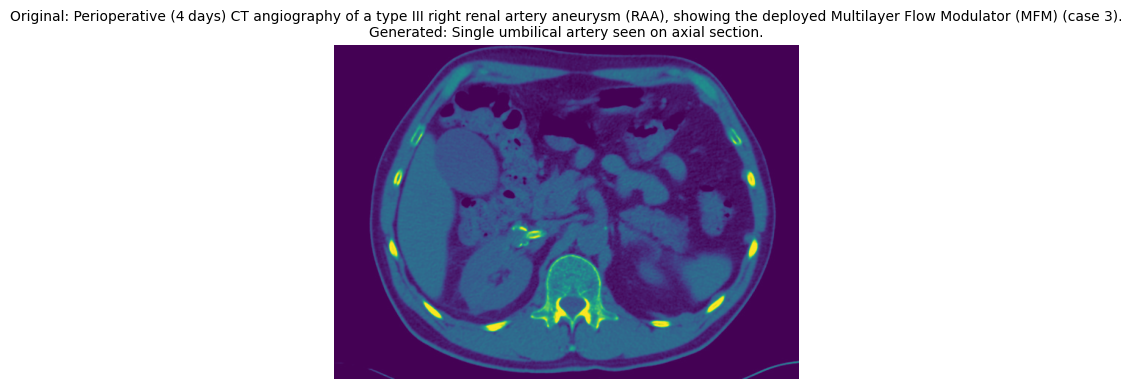

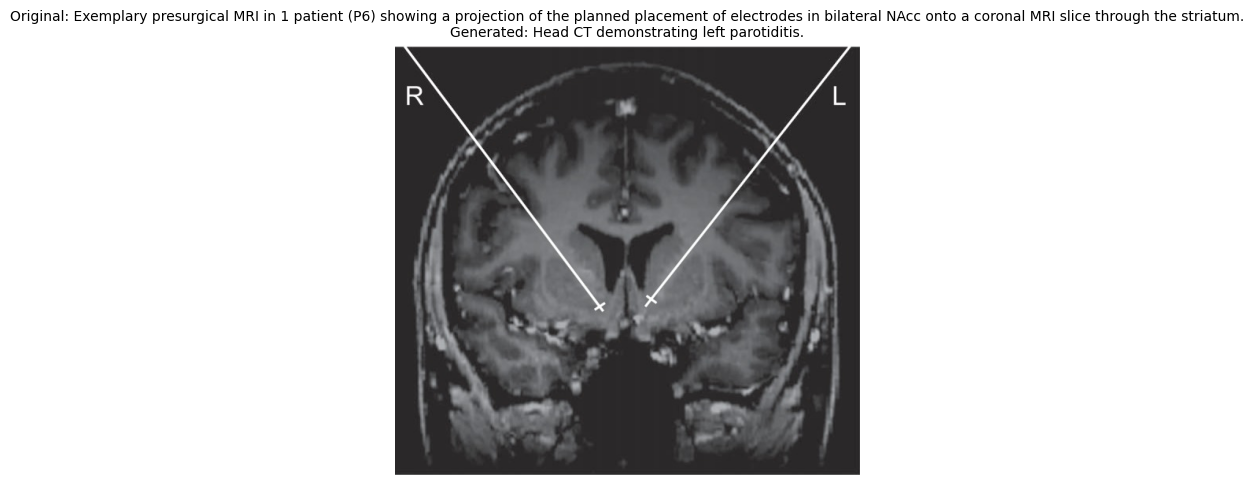

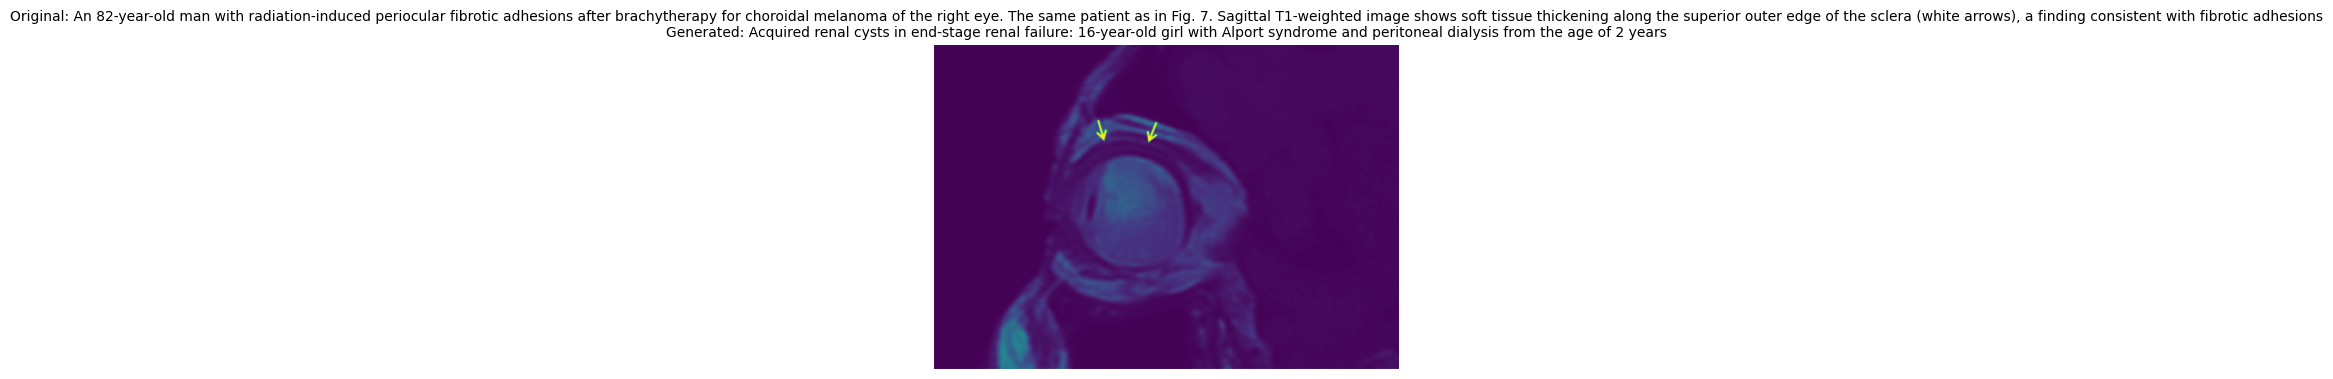

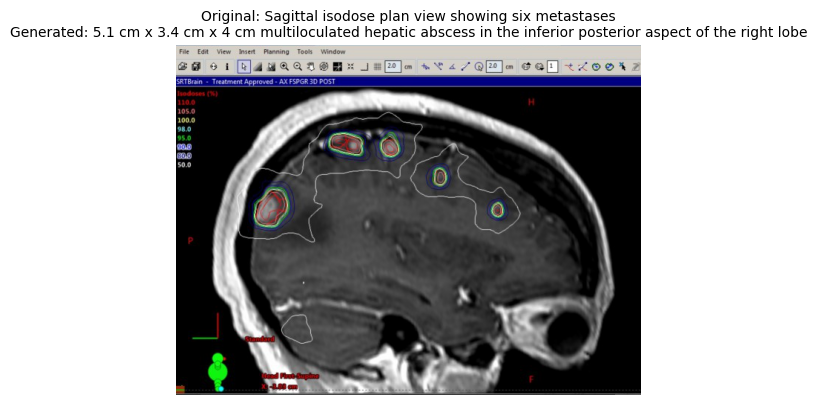

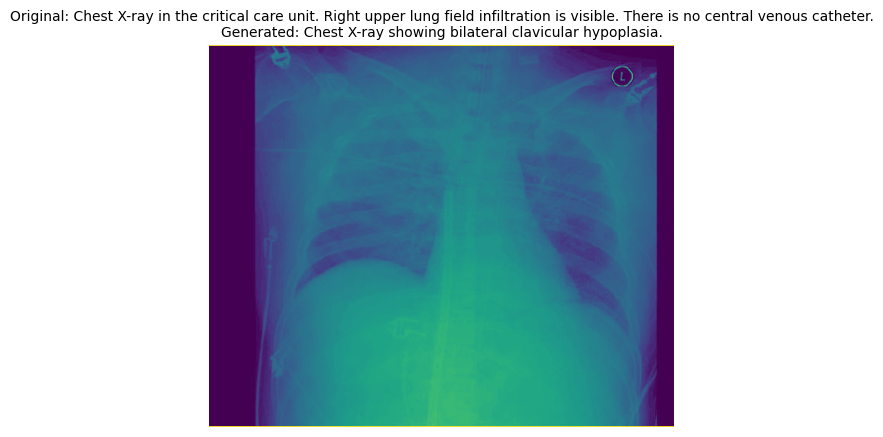

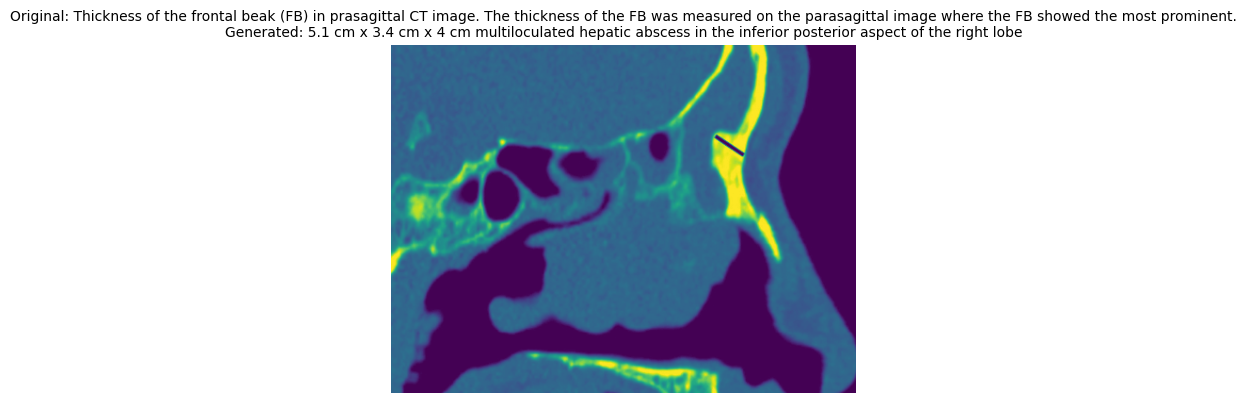

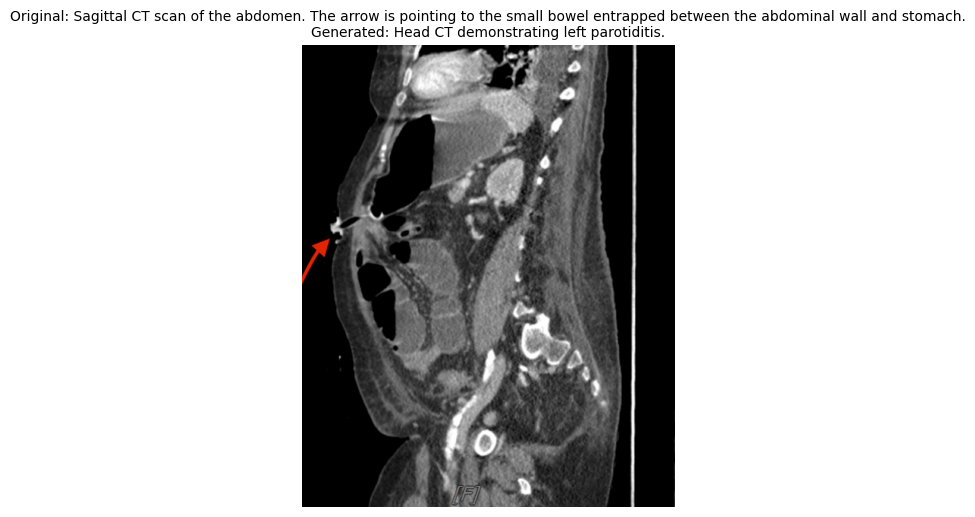

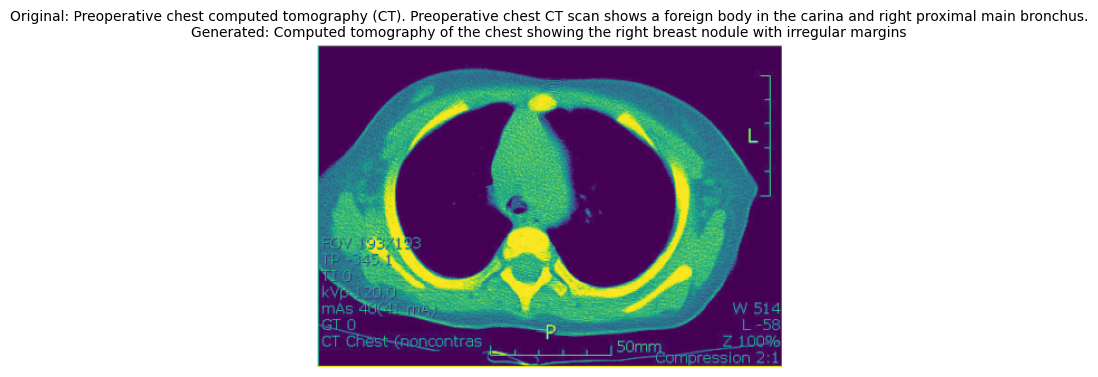

In [15]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt

# Load the saved features and captions
features = np.load("features.npy")  # Load features from the .npy file
with open("captions.json", "r") as f:
    captions = json.load(f)  # Load captions from the .json file

# Ensure clustered_captions is created during clustering
# Example: clustered_captions = {caption: cluster for caption, cluster in zip(captions, clusters)}

# Select 10 random indices
random_indices = random.sample(range(len(features)), 10)

# Iterate over the selected indices
for idx in random_indices:
    # Get the features, original caption, and image for the current index
    new_image_features = features[idx]
    original_caption = captions[idx]
    image = images[idx]  # Assuming `images` contains the original image objects

    # Predict the cluster for the current image
    predicted_cluster = clf.predict([new_image_features])[0]

    # Retrieve all captions belonging to the predicted cluster
    cluster_captions = [caption for caption, cluster in clustered_captions.items() if cluster == predicted_cluster]

    # Select a representative caption (e.g., the first one or a random one)
    if cluster_captions:
        representative_caption = cluster_captions[0]  # You can also use random.choice(cluster_captions)
    else:
        representative_caption = "No captions found for the predicted cluster."

    # Plot the image with captions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original: {original_caption}\nGenerated: {representative_caption}", fontsize=10)
    plt.show()

## Sentence Embeddings + Clustering

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for captions
embeddings = model.encode(captions)

# Cluster embeddings into k groups
k = 30  # Adjust the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Replace captions with cluster labels
labels = clusters
print(f"Number of clusters: {k}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Number of clusters: 30


Accuracy: 0.4505127991328275
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.31      0.31       490
           1       0.24      0.26      0.25       136
           2       0.66      0.64      0.65       756
           3       0.51      0.52      0.52       204
           4       0.45      0.36      0.40       121
           5       0.57      0.61      0.59       809
           6       0.23      0.23      0.23       320
           7       0.50      0.48      0.49       309
           8       0.46      0.45      0.45       568
           9       0.57      0.56      0.57       399
          10       0.42      0.44      0.43       498
          11       0.36      0.44      0.39       131
          12       0.27      0.25      0.26       353
          13       0.27      0.26      0.26       234
          14       0.46      0.47      0.47       273
          15       0.34      0.35      0.34       529
          16       0.58     

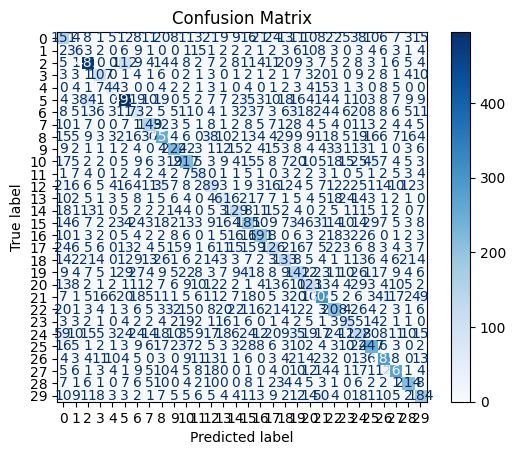

Model saved as decision_tree_model_sentence_embeddings.pkl


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Ensure embeddings and labels are defined
# embeddings = model.encode(captions)  # Generated sentence embeddings
# labels = clusters  # Cluster labels from KMeans

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
joblib.dump(clf, "decision_tree_model_sentence_embeddings.pkl")
print("Model saved as decision_tree_model_sentence_embeddings.pkl")

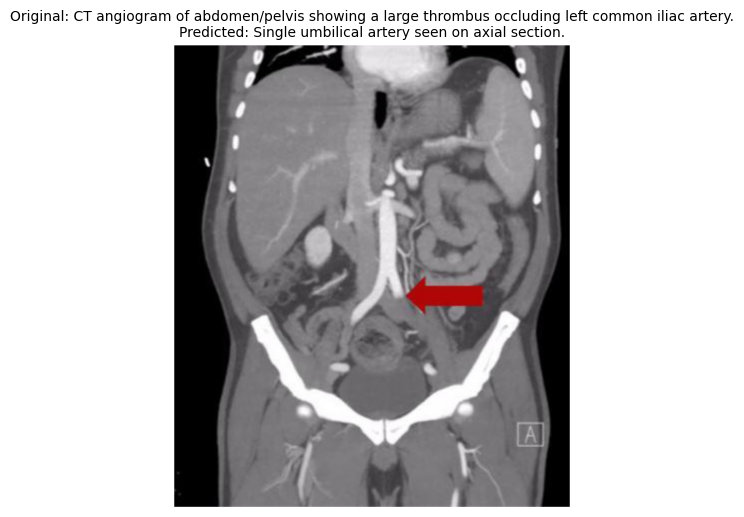

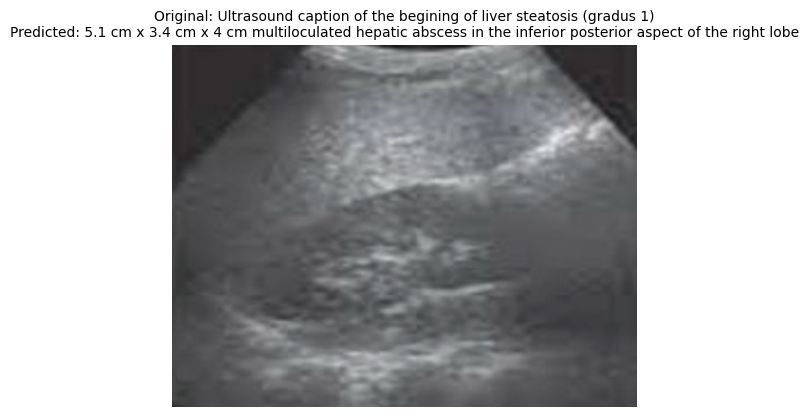

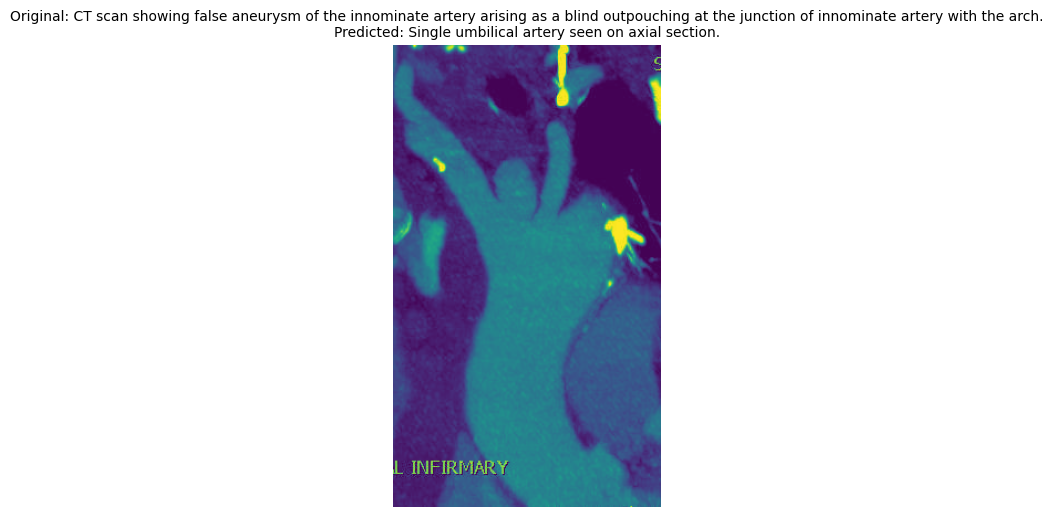

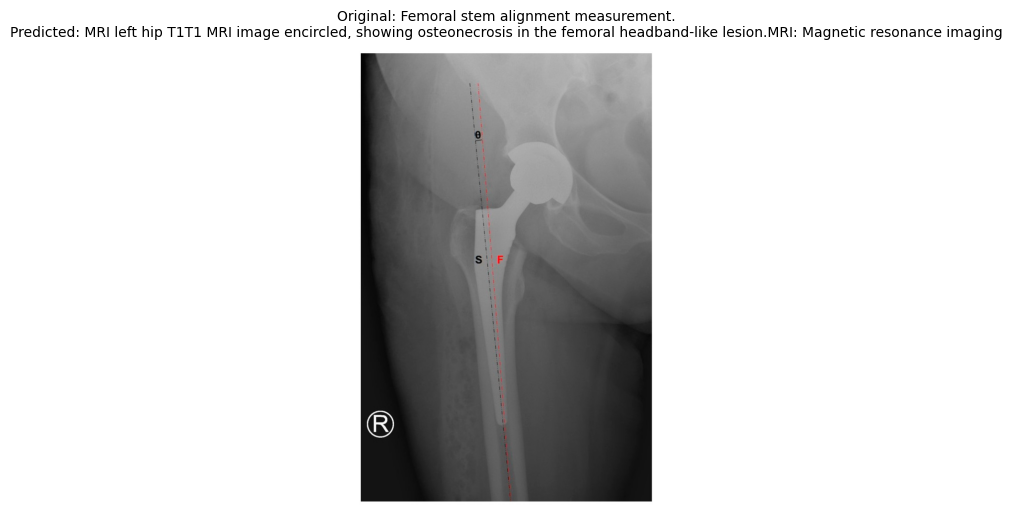

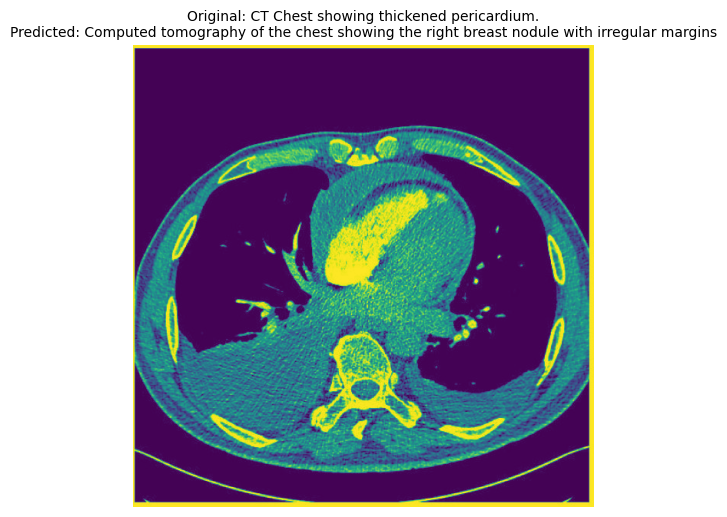

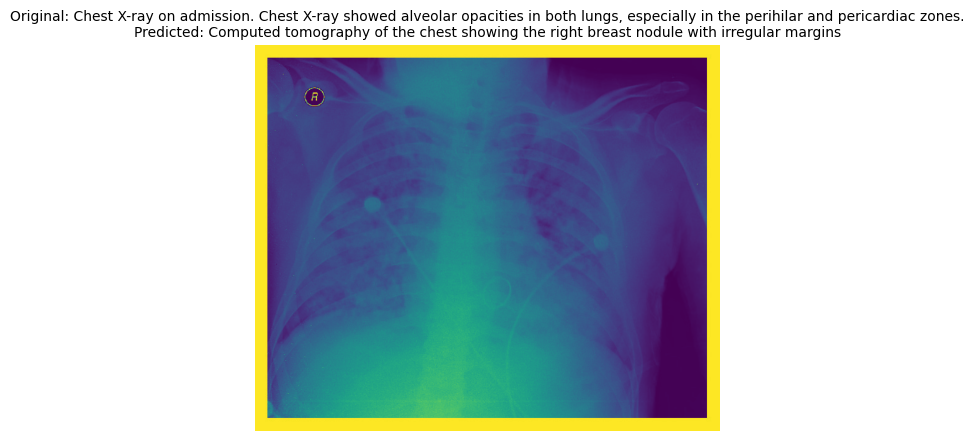

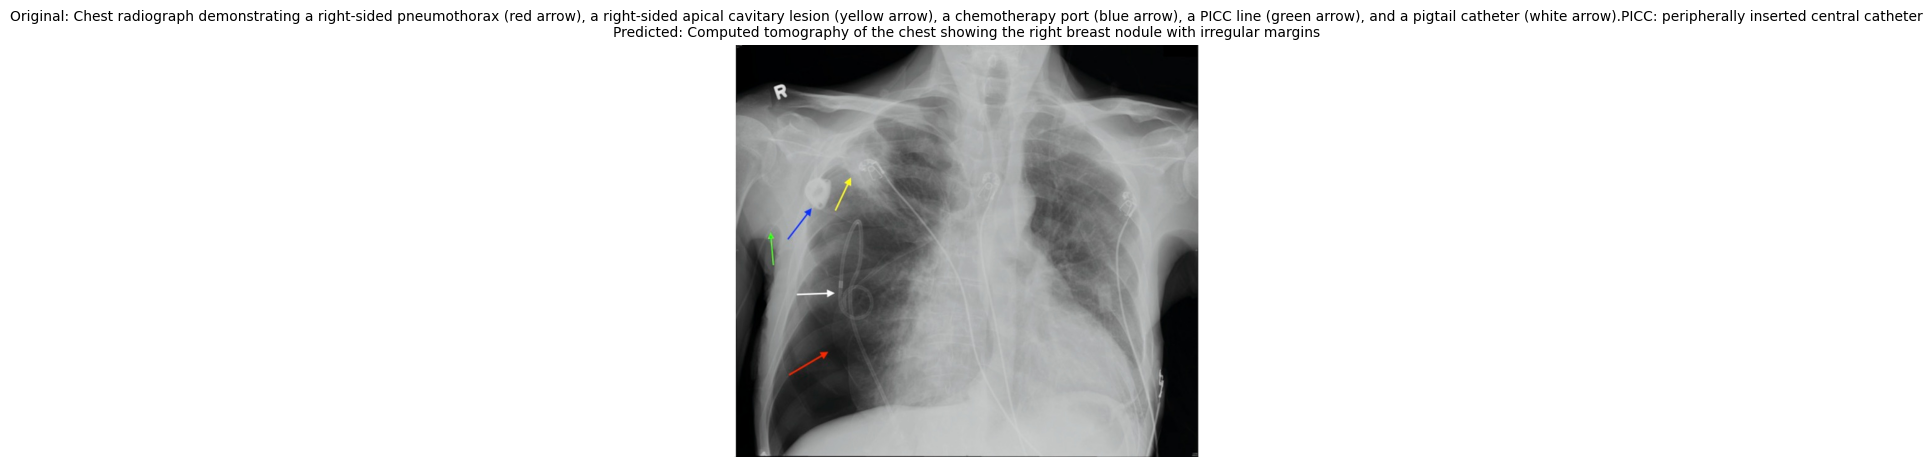

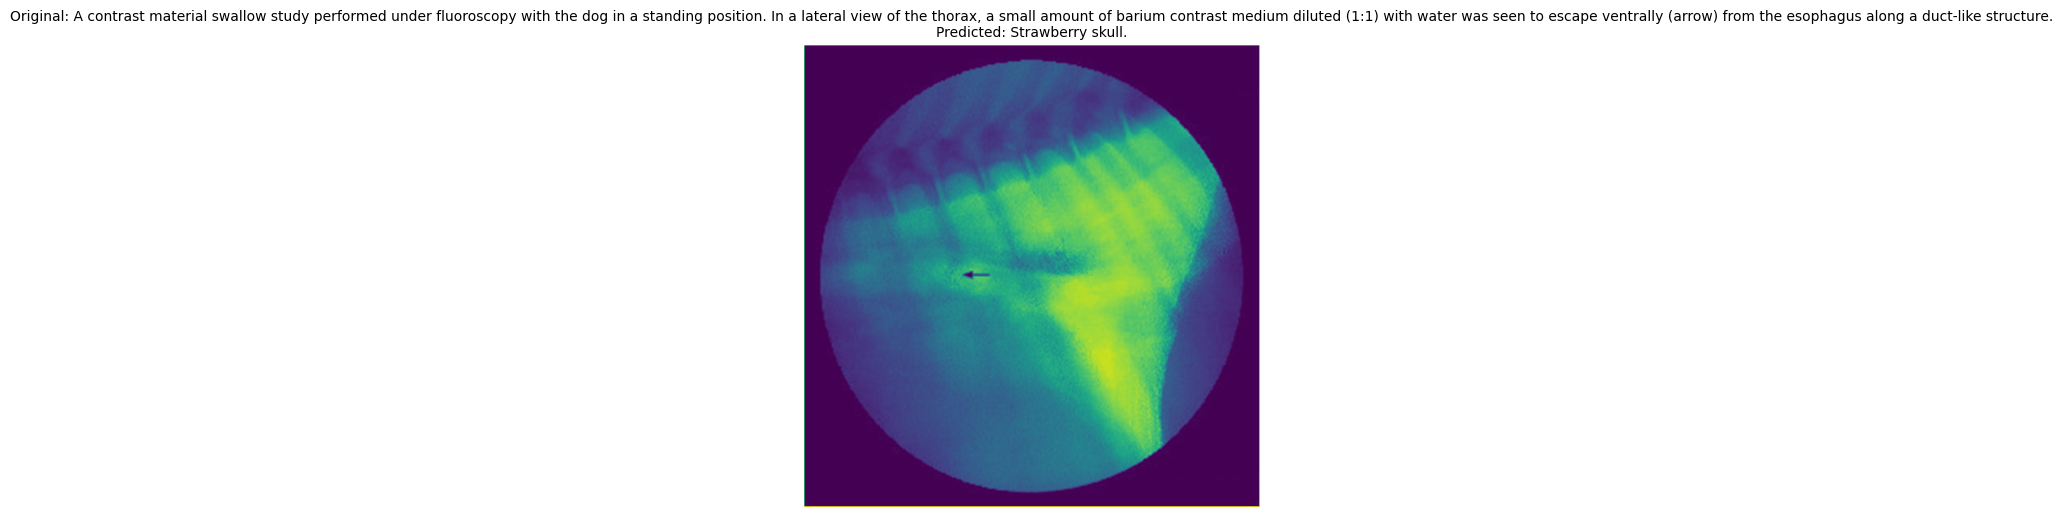

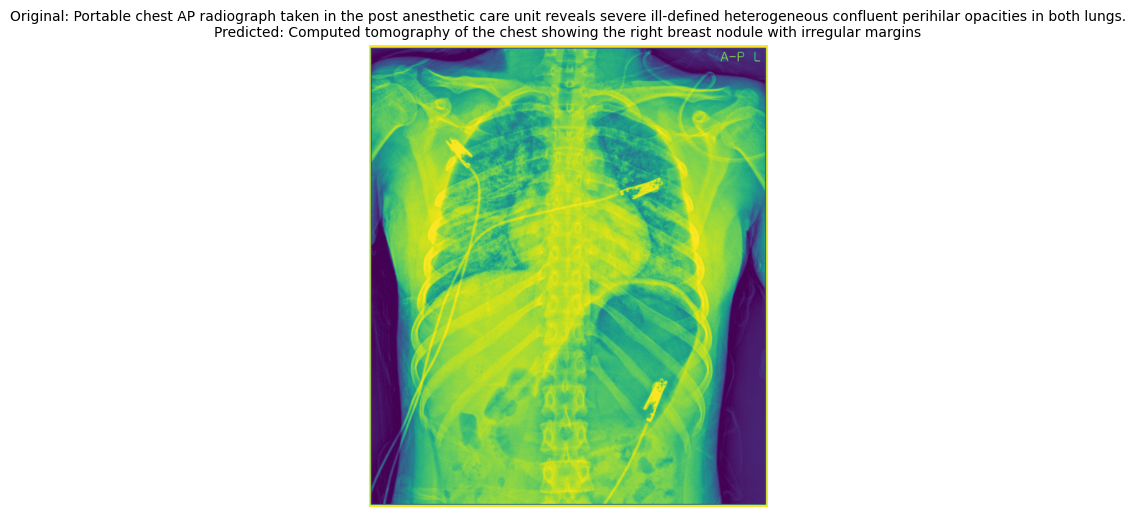

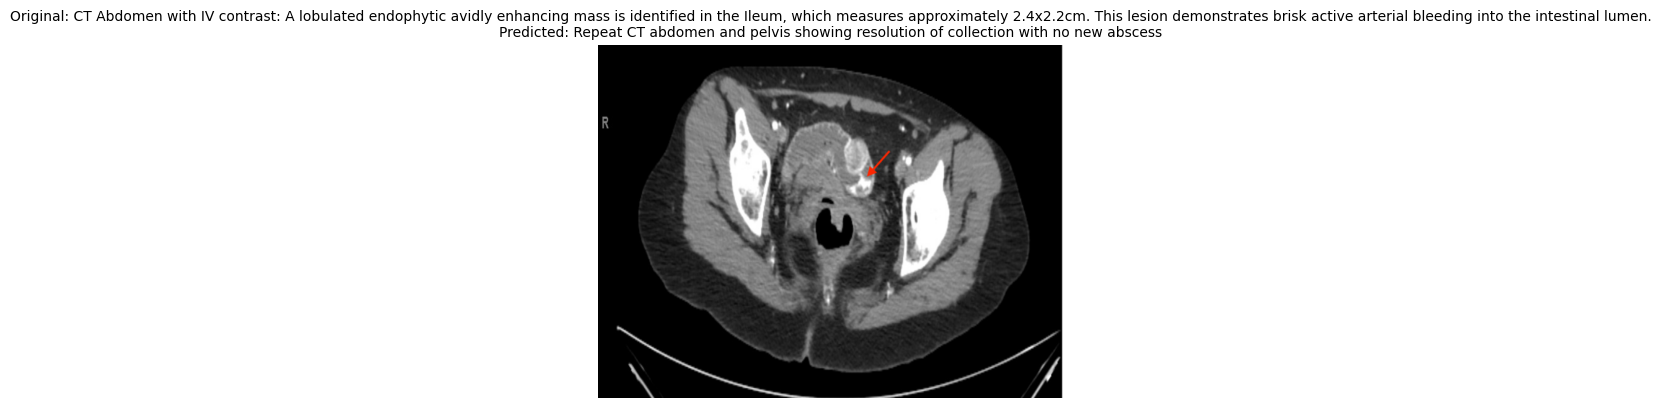

In [18]:
import random
import matplotlib.pyplot as plt

# Ensure embeddings, labels, and images are defined
# embeddings = model.encode(captions)  # Generated sentence embeddings
# labels = clusters  # Cluster labels from KMeans
# images = [...]  # List of original images corresponding to captions

# Select 10 random indices
random_indices = random.sample(range(len(embeddings)), 10)

# Iterate over the selected indices
for idx in random_indices:
    # Get the features, original caption, and image for the current index
    new_image_features = embeddings[idx]
    original_caption = captions[idx]
    image = images[idx]  # Assuming `images` contains the original image objects

    # Predict the cluster for the current image
    predicted_cluster = clf.predict([new_image_features])[0]

    # Retrieve all captions belonging to the predicted cluster
    cluster_captions = [caption for caption, cluster in zip(captions, labels) if cluster == predicted_cluster]

    # Select a representative caption (e.g., the first one or a random one)
    if cluster_captions:
        representative_caption = cluster_captions[0]  # You can also use random.choice(cluster_captions)
    else:
        representative_caption = "No captions found for the predicted cluster."

    # Plot the image with captions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original: {original_caption}\nPredicted: {representative_caption}", fontsize=10)
    plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.827232552322188


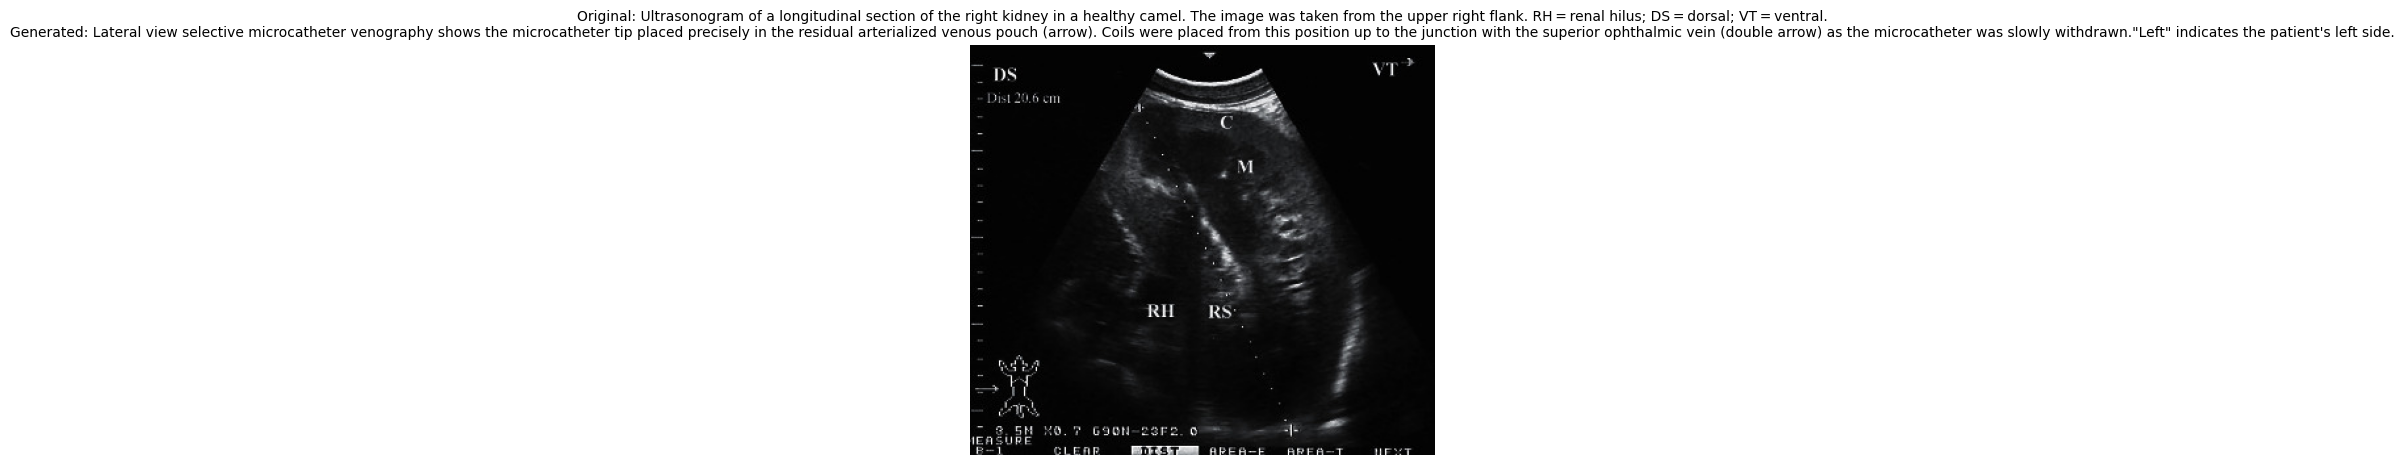

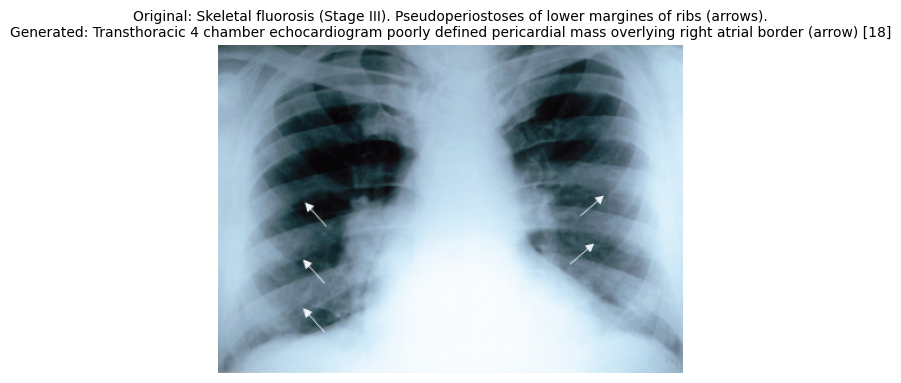

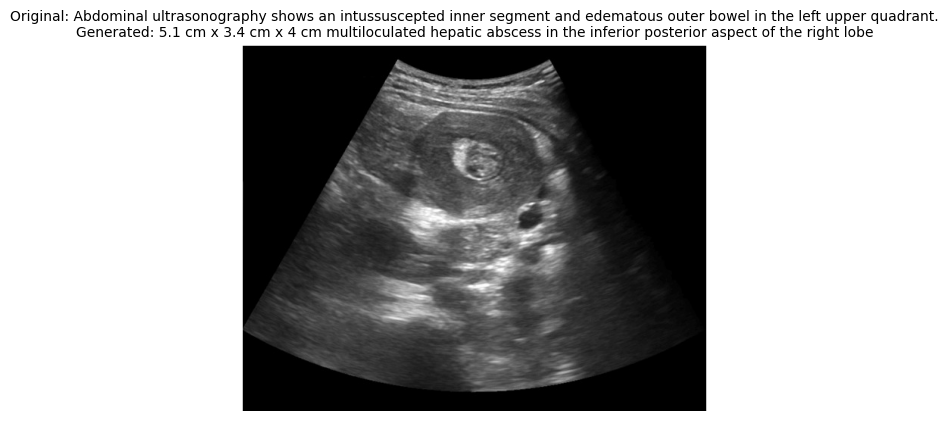

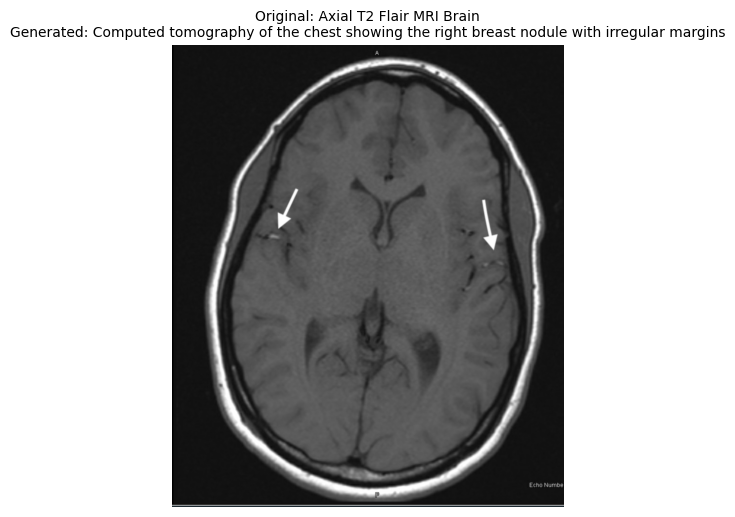

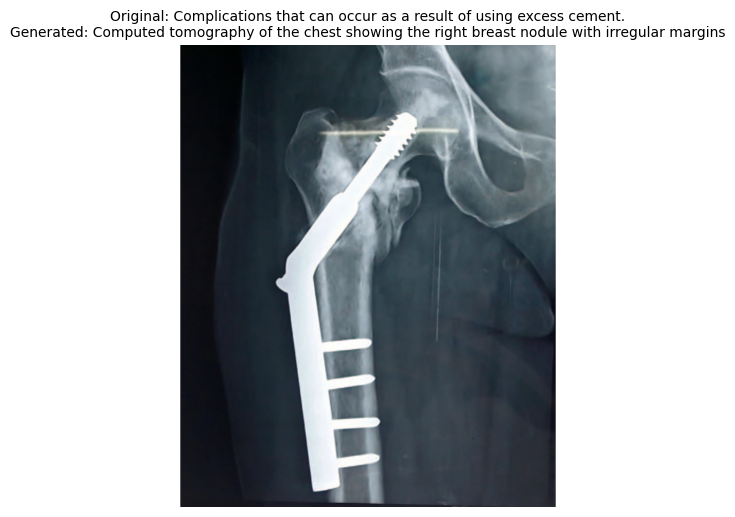

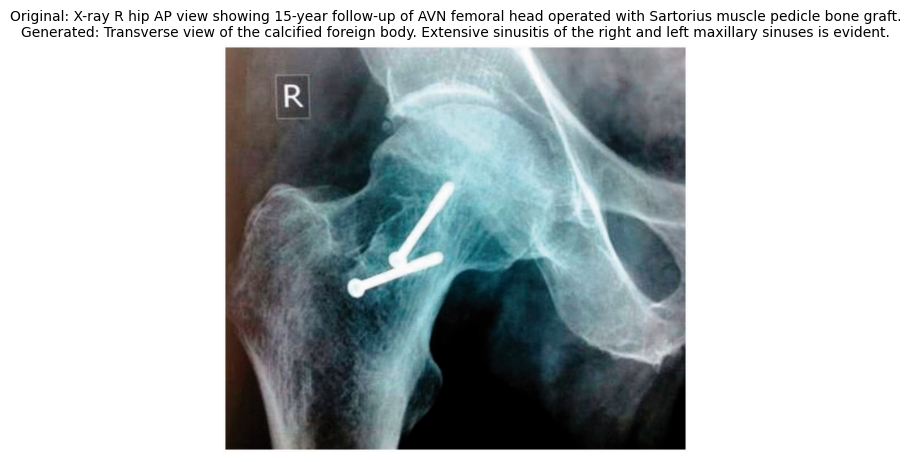

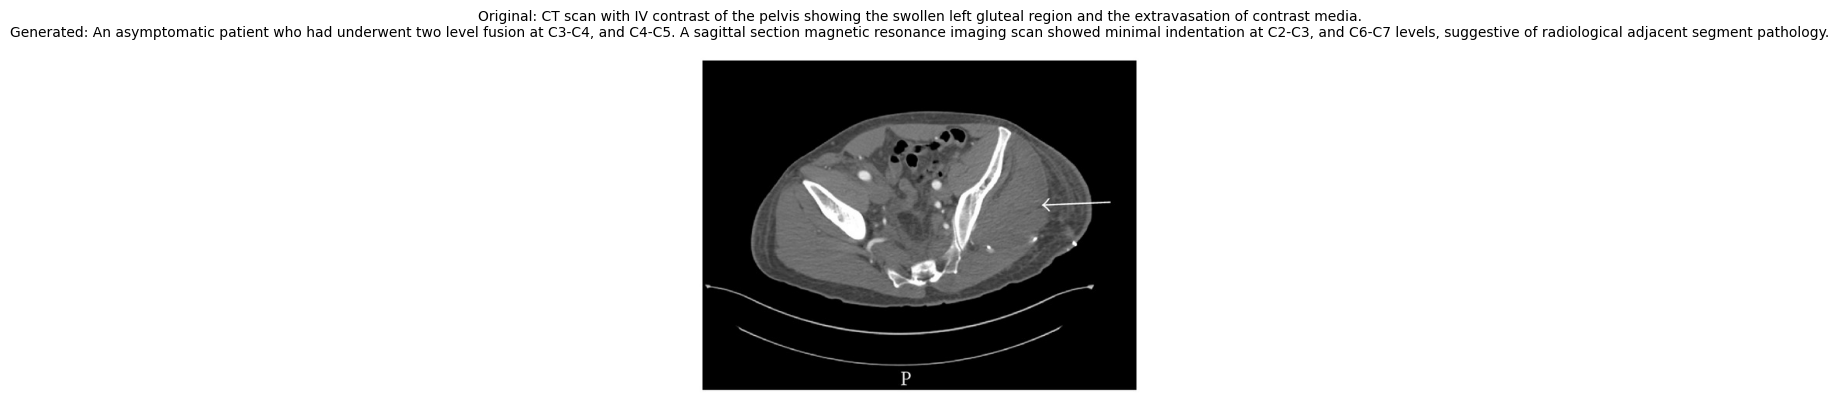

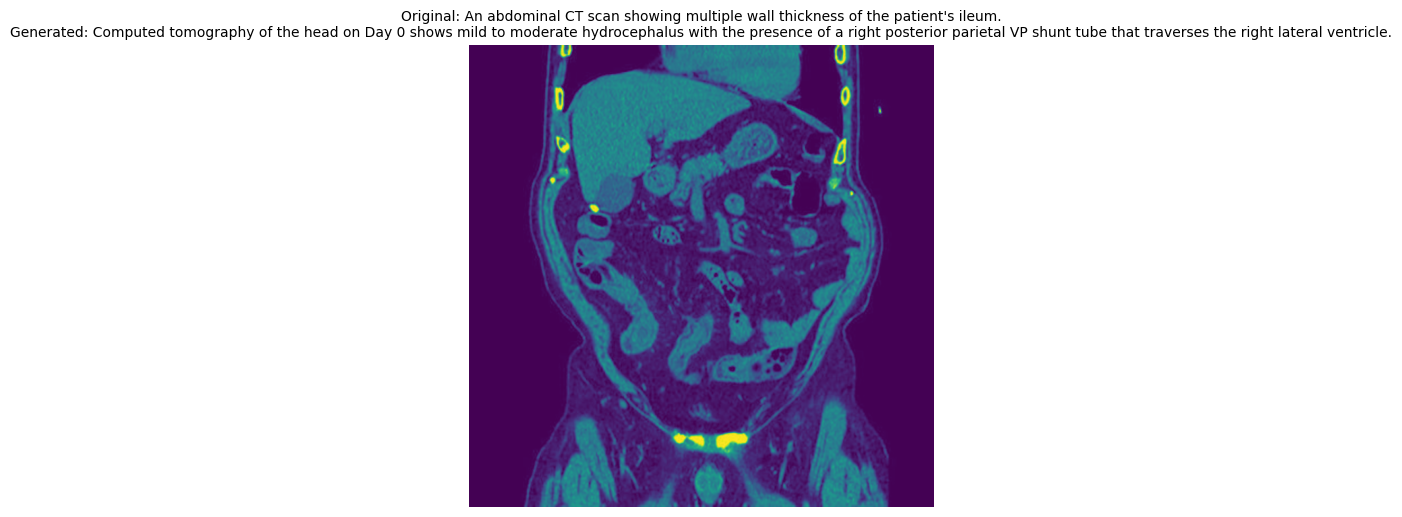

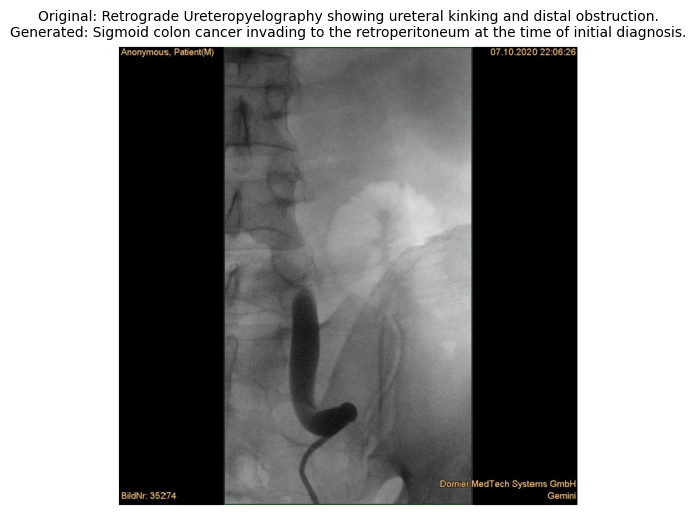

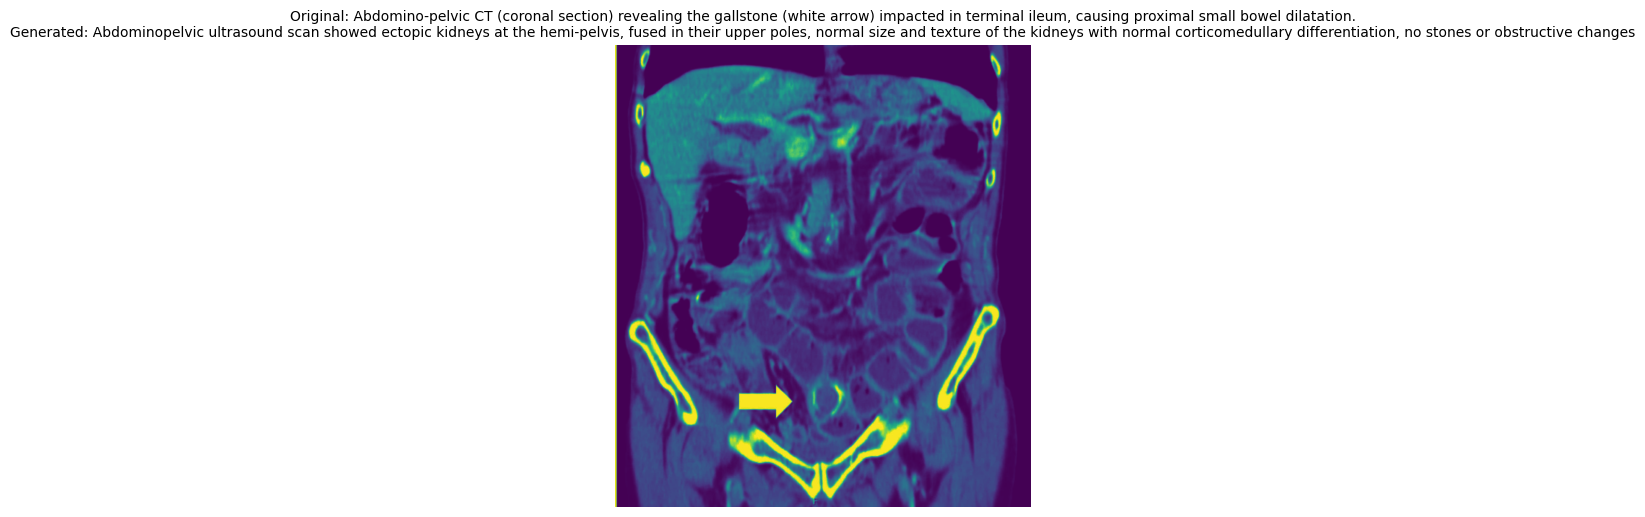

In [20]:
import random
import matplotlib.pyplot as plt

# Ensure you have the following variables:
# - X_test: Test features
# - y_test: True labels for the test set
# - y_pred: Predicted labels from the Random Forest Classifier
# - images: List of images
# - captions: List of original captions
# - labels: Cluster labels for captions (if clustering was used)

# Map cluster labels to captions (if clustering was used)
# Example: clustered_captions = {caption: cluster for caption, cluster in zip(captions, labels)}
# If not using clustering, you can skip this step.

# Select 10 random indices from the test set
random_indices = random.sample(range(len(X_test)), 10)

# Iterate over the selected indices
for idx in random_indices:
    # Get the original caption, predicted cluster, and image for the current index
    original_caption = captions[idx]
    predicted_cluster = y_pred[idx]
    image = images[idx]  # Assuming `images` contains the original image objects

    # Retrieve all captions belonging to the predicted cluster (if clustering was used)
    # If not using clustering, you can directly use the predicted label as the generated caption
    cluster_captions = [caption for caption, cluster in zip(captions, labels) if cluster == predicted_cluster]

    # Select a representative caption (e.g., the first one or a random one)
    if cluster_captions:
        representative_caption = cluster_captions[0]  # You can also use random.choice(cluster_captions)
    else:
        representative_caption = "No captions found for the predicted cluster."

    # Plot the image with captions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original: {original_caption}\nGenerated: {representative_caption}", fontsize=10)
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(captions)  # Encode the captions into numerical labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()